# Assignment 5: Epipolar geometry and triangulation

In [3]:
#imports
import numpy as np
from matplotlib import pyplot as plt
from a5_utils import *
import cv2 as cv2
from UZ_utils import *

## Exercise 1: Disparity

In this assignment we will focus on calculating disparity from a two-camera system. Our
analysis will be based on a simplified stereo system, where two identical cameras are
aligned with parallel optical axes and their image planes (CCD sensors) lie on the same
plane (Image 1a).

a) the further the object is the lower the disparity

### B)
Write a script that computes the disparity for a range of values of pz. Plot the values
to a figure and set the appropriate units to axes. Use the following parameters of
the system: focal length is f = 2:5mm and stereo system baseline is T = 12cm.

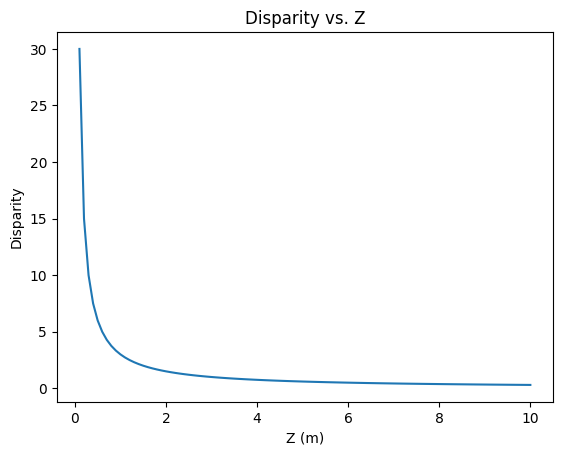

In [6]:

def disparity(pz, FOCAL_LENGTH=0.25, BASELINE=12):
  return BASELINE * FOCAL_LENGTH / pz


pz_s = np.linspace(0.1, 10, 100)
d_s = disparity(pz_s)

plt.plot(pz_s, d_s)
plt.xlabel('Z (m)')
plt.ylabel('Disparity')
plt.title('Disparity vs. Z')
plt.show()


### C)
In order to get a better grasp on the idea of distance and disparity, you will calculate
the numbers for a specific case. We will take the parameters from a specification of
a commercial stereo camera Bumblebee2 manufactured by the company PointGray:
f = 2.5mm, T = 12cm, whose image sensor has a resolution of 648x488 pixels that
are square and the width of a pixel is 7.4um. We assume that there is no empty
space between pixels and that both cameras are completely parallel and equal. Lets
say that we use this system to observe a (point) object that is detected at pixel 550
in x axis in the left camera and at the pixel 300 in the right camera. How far is the
object (in meters) in this case? How far is the object if the object is detected at
pixel 540 in the right camera? Solve this task analytically and bring your solution
to the presentation of the exercise.

In [ ]:
focal = 0.25
t = 12
height =  488
width =  648
pixel_size = 7.5e-6


# 540 in infinity and beyond
# couple of cm


## Exercise 2: Fundamental matrix, epipoles, epipolar lines